In [1]:
%load_ext tensorboard

import tifffile
import numpy as np
from pathlib import Path
from typing import Union, List, Tuple
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch import no_grad, cuda
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms.v2 as transforms_v2

from datetime import datetime

import sys
import os
sys.path.append("/localscratch/project/the_exceptionals/model")
from unet import UNet

sys.path.append("/localscratch/project/the_exceptionals/util/")
from visualize import show_random_dataset_image_with_prediction
from helper import compute_receptive_field

sys.path.append("/localscratch/project/the_exceptionals/data/")
#from local import (
#    CellDataset,
#    show_random_dataset_image,
#    show_one_image
#)
import local
from train import train

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
img_path = "/localscratch/project/data2d/norm_img/val/images/MAX_C3-03022022_Label49_t1_100x_0.21_02_POS_current.vsi - 405, 488, 640.tif scaled.tif"
mask_path = "/localscratch/project/data2d/val_images2D/masks/MAX_C3-03022022_Label49_t1_100x_0.21_02_POS_current.vsi - 405, 488, 640.tif scaled.tif"
checkpoint_path = "/localscratch/project/the_exceptionals/util/expNone_MSE_256_epoch_162.pth"

In [4]:
unet = UNet(depth=3, in_channels=1, out_channels=1, num_fmaps=64, final_activation=None, padding = "valid").to(device)
unet.load_state_dict(torch.load(checkpoint_path))

<All keys matched successfully>

In [5]:
dummy = torch.zeros(1, 1, 256, 256)

In [6]:
dummy_out = unet(dummy.to(device))

In [7]:
dummy_out.shape

torch.Size([1, 1, 216, 216])

In [8]:
testData = local.TestDataset(img_path, mask_path, slide = dummy_out.shape[3])

In [9]:
testLoader = DataLoader(testData, batch_size = 16, num_workers = 8, drop_last = False)

In [10]:
rfs = compute_receptive_field(depth = 3, kernel_size = 3, downsample_factor = 2)
ncols = testData.ncols
nrows = testData.nrows


In [11]:
image, mask = testData[40]

In [12]:
prediction = unet(image.unsqueeze(dim= 0).to(device))

In [13]:
prediction.shape

torch.Size([1, 1, 216, 216])

In [14]:
loss_function = nn.MSELoss()

In [15]:
class DiceCoefficient(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps

    # the dice coefficient of two sets represented as vectors a, b ca be
    # computed as (2 *|a b| / (a^2 + b^2))
    def forward(self, prediction, target):
        intersection = (prediction * target).sum()
        union = (prediction * prediction).sum() + (target * target).sum()
        return 2 * intersection / union.clamp(min=self.eps)

In [16]:
from helper import validate

In [23]:
stitched_img, loss, metric = validate(unet, testLoader, ncols, nrows, cropsize = 256, loss_function = loss_function, metric = DiceCoefficient(), device = device)

In [41]:
loss

0.0008649629838441797

In [42]:
metric

0.0

(array([3.593470e+05, 4.286057e+06, 9.609000e+03, 4.430000e+03,
        2.742000e+03, 1.821000e+03, 9.400000e+02, 4.810000e+02,
        1.380000e+02, 3.500000e+01]),
 array([-0.11902662, -0.0087145 ,  0.10159762,  0.21190974,  0.32222185,
         0.43253398,  0.54284608,  0.65315819,  0.76347035,  0.87378246,
         0.98409456]),
 <BarContainer object of 10 artists>)

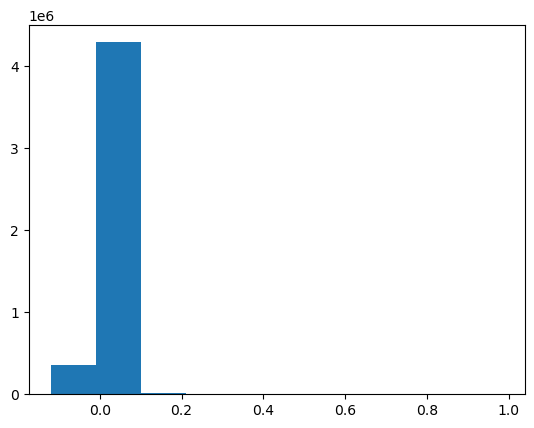

In [25]:
plt.hist(stitched_img.flatten())

In [29]:
mask = skimage.io.imread(mask_path)

(-0.5, 2159.5, 2159.5, -0.5)

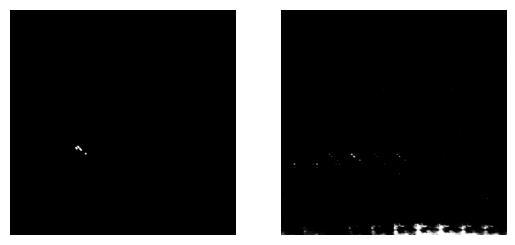

In [40]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(mask, cmap = "gray")
ax2.imshow(stitched_img > 0.05, cmap="gray")
ax1.axis("off")
ax2.axis("off")

In [18]:
batch_of_images = np.array([x.numpy()[0] for  x, y in testData])
stitched = batch_of_images.reshape(testData.ncols * testData.cropsize, testData.nrows * testData.cropsize)

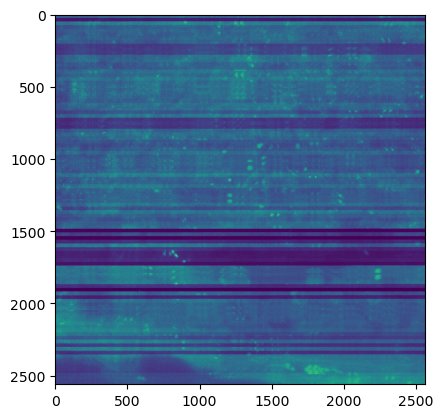

In [19]:
plt.imshow(stitched)